## Imports

In [291]:
!pip install -r requirements.txt

In [292]:
# !pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug
# !pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
# !pip install py7zr #Sur colab, sinon bug
# !pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

Cloning into 'cartogether'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 224 (delta 57), reused 44 (delta 23), pack-reused 108
Receiving objects: 100% (224/224), 482.99 KiB | 5.31 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/home/onyxia/work/30daysmapchallenge2022/day20_favourite/cartogether/cartogether/cartogether
Processing /home/onyxia/work/30daysmapchallenge2022/day20_favourite/cartogether/cartogether/cartogether
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cartiflette: filename=cartiflette-0.0.1-py3-none-any.whl size=18118 sha256=99aba16fcebff277bee8138b40ecfabfb34a477394098e4e0edace7cdaa3bb03
  Stored in directory: /tmp/pip-ephem-wheel-cache-n0ndojva/wheels/2a/d2/07/30560acc2b9b9ee6fb8c74e2eb8ebcde1e3db4b887767cb084
Successfully built cartiflette
  Attempting

In [294]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import time
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette.download import get_vectorfile_ign

In [ ]:
import functions as fc

In [208]:
url_ffe = 'http://www.echecs.asso.fr/'
suffix_all_clubs = 'ListeClubs.aspx?Action=CLUBCOMITE&ComiteRef='
suffix_all_players_club = 'ListeJoueurs.aspx?Action=JOUEURCLUBREF&ClubRef='

## Faire liste clubs

In [209]:
def get_infos_club_from_row(row):
    fields = row.find_all('td')
    departement = fields[0].text.strip()
    commune = fields[1].text.strip()
    club = fields[2].text.strip()
    try:
        suffix_club = fields[2].find('a').get('href')
        ref_club = ''.join(c for c in suffix_club if c.isdigit())
    except:
        suffix_club = None
        ref_club = None
    return [club, ref_club, suffix_club, commune, departement]

In [210]:
def get_all_clubs_in_departement(departement):
    
    liste_clubs_departement = []
    
    url = url_ffe + suffix_all_clubs + "{:02d}".format(departement)
    request_text = requests.get(url).text
    soup = BeautifulSoup(request_text, 'html.parser')
    
    try:
        zone = soup.find('div', {'class':'page-mid'})
        tableau = zone.find('table')
        rows = tableau.find_all('tr')

        for i in range(1,len(rows)):
            liste_clubs_departement.append(get_infos_club_from_row(rows[i]))
    except:
        pass
    return liste_clubs_departement

In [211]:
def get_all_clubs_france():
    liste_clubs = []
    for departement in tqdm(range(100)):
        liste_clubs += get_all_clubs_in_departement(departement)
        time.sleep(1)
    liste_clubs += get_all_clubs_in_departement('2A')
    liste_clubs += get_all_clubs_in_departement('2B')
    return liste_clubs

In [212]:
liste_clubs = get_all_clubs_france()

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [213]:
df_clubs = pd.DataFrame(liste_clubs, columns = ['club_name', 'club_reference', 'suffix_url', 'commune', 'departement'])

In [214]:
df_clubs

,club_name,club_reference,suffix_url,commune,departement
0,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
1,Club d'Echecs de Belley,3232,FicheClub.aspx?Ref=3232,BELLEY,01
2,Cercle d'Echecs Bressan,1168,FicheClub.aspx?Ref=1168,BOURG EN BRESSE,01
3,La Tour de la Dombes,1171,FicheClub.aspx?Ref=1171,CHATILLON SUR CHALARONNE,01
4,Amicale Echecs,2725,FicheClub.aspx?Ref=2725,GEX,01
...,...,...,...,...,...
812,C.E. Air France Siege Roissy,934,FicheClub.aspx?Ref=934,ROISSY EN FRANCE,95
813,L'Echiquier de Santeuil,2506,FicheClub.aspx?Ref=2506,SANTEUIL,95
814,L'Echiquéenne de Survilliers,2185,FicheClub.aspx?Ref=2185,SURVILLIERS,95
815,Le Pion Passé Vaurealien,2810,FicheClub.aspx?Ref=2810,VAUREAL,95


In [261]:
nombres_clubs = df_clubs.groupby('departement', as_index=False)['club_name'].count().sort_values(by='club_name', ascending=False)
nombres_clubs

,departement,club_name
71,75,33
63,67,30
55,59,29
64,68,22
65,69,22
...,...,...
4,05,2
40,43,1
86,90,1
54,58,1


## Faire liste joueurs

In [215]:
def get_infos_player_from_row(row):
    fields = row.find_all('td')
    elo_lent = int(''.join(c for c in fields[4].text if c.isdigit()))
    elo_rapide = int(''.join(c for c in fields[5].text if c.isdigit()))
    elo_blitz = int(''.join(c for c in fields[6].text if c.isdigit()))
    category = fields[7].text.strip()
    age = category[:3]
    sex = category[-1]
    club_name = fields[9].text.strip()
    return [elo_lent, elo_rapide, elo_blitz, category, age, sex, club_name]

In [216]:
def get_all_players_in_club(ref_club):
    
    liste_players_clubs = []
    
    url = url_ffe + suffix_all_players_club + str(ref_club)
    request_text = requests.get(url).text
    soup = BeautifulSoup(request_text, 'html.parser')
    
    try:
        zone = soup.find('div', {'class':'page-mid'})
        tableau = zone.find('table')
        rows = tableau.find_all('tr')
        
        for i in range(1,len(rows)):
            liste_players_clubs.append(get_infos_player_from_row(rows[i]))
    except:
        pass
    return liste_players_clubs

In [217]:
def get_all_players_france():
    liste_players = []
    for club in tqdm(df_clubs['club_reference'].drop_duplicates()):
        liste_players += get_all_players_in_club(club)
        time.sleep(1)
    return liste_players

In [218]:
liste_players = get_all_players_france()

100%|██████████| 817/817 [09:18<00:00,  1.46it/s]


In [219]:
df_players = pd.DataFrame(liste_players, columns = ['elo_lent', 'elo_rapide', 'elo_blitz', 'category', 'age', 'sex', 'club_name'])

In [263]:
nombres_joueurs = df_players.groupby('club_name', as_index=False)['elo_lent'].count().sort_values(by='elo_lent', ascending=False)
nombres_joueurs

,club_name,elo_lent
0,"""Le Gambit ""de Muret",40
255,Club d'Echecs des 3 Pays,40
558,LEC Echiquier Limousin,40
561,La Ciotat Echecs (LCE),40
250,Club d'Echecs de l'Arpajonnais,40
...,...,...
585,La Tour Du Parc Ste Marie Aux Mines,4
468,Evry Grand Roque,2
254,Club d'Echecs de la Tour Houdanaise,2
713,Paris Top Chess Club,1


## Jointure

In [221]:
df = pd.merge(df_players, df_clubs, on='club_name')

In [222]:
df

,elo_lent,elo_rapide,elo_blitz,category,age,sex,club_name,club_reference,suffix_url,commune,departement
0,1009,960,960,PouM,Pou,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
1,1199,1199,1199,SenF,Sen,F,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
2,1199,1260,1260,BenM,Ben,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
3,1009,799,799,PouM,Pou,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
4,1199,999,999,BenF,Ben,F,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
...,...,...,...,...,...,...,...,...,...,...,...
20598,1099,999,999,PupF,Pup,F,Carre Clay - Chess Boxing,3256,FicheClub.aspx?Ref=3256,VILLIERS LE BEL,95
20599,1399,1199,1199,SenM,Sen,M,Carre Clay - Chess Boxing,3256,FicheClub.aspx?Ref=3256,VILLIERS LE BEL,95
20600,1199,999,999,BenF,Ben,F,Carre Clay - Chess Boxing,3256,FicheClub.aspx?Ref=3256,VILLIERS LE BEL,95
20601,1399,1199,1199,JunF,Jun,F,Carre Clay - Chess Boxing,3256,FicheClub.aspx?Ref=3256,VILLIERS LE BEL,95


In [237]:
df_departements = df.groupby('departement', as_index=False)['elo_lent'].mean()
df_departements

,departement,elo_lent
0,01,1246.478261
1,02,1251.921260
2,03,1322.452632
3,04,1271.544118
4,05,1360.135593
...,...,...
87,91,1272.769663
88,92,1277.595912
89,93,1255.867841
90,94,1233.218182


## Create map

In [227]:
france = get_vectorfile_ign(
  level = "COMMUNE",
  field = "metropole",
  source = "COG",
  provider="opendatarchives"
  )

opendatarchives
COG


Downloading: 100%|██████████| 244M/244M [02:45<00:00, 1.54MiB/s] 
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [238]:
carte_departements = france.dissolve(by='INSEE_DEP', aggfunc='sum')
carte_departements

,geometry,ID,NOM_M,NOM,INSEE_REG
INSEE_DEP,,,,,
01,"POLYGON ((838383.200 6570485.800, 838483.800 6...",DEPARTEM_FXX_00000000001,AIN,Ain,84
02,"POLYGON ((708719.000 6956305.000, 708718.700 6...",DEPARTEM_FXX_00000000002,AISNE,Aisne,32
03,"POLYGON ((664478.800 6602292.500, 664503.600 6...",DEPARTEM_FXX_00000000005,ALLIER,Allier,84
04,"POLYGON ((910451.400 6342553.000, 910484.700 6...",DEPARTEM_FXX_00000000006,ALPES-DE-HAUTE-PROVENCE,Alpes-de-Haute-Provence,93
05,"POLYGON ((933490.000 6411083.800, 933530.500 6...",DEPARTEM_FXX_00000000007,HAUTES-ALPES,Hautes-Alpes,93
...,...,...,...,...,...
91,"POLYGON ((629444.100 6836670.800, 629365.600 6...",DEPARTEM_FXX_00000000092,ESSONNE,Essonne,11
92,"POLYGON ((642868.900 6869240.500, 642874.900 6...",DEPARTEM_FXX_00000000093,HAUTS-DE-SEINE,Hauts-de-Seine,11
93,"POLYGON ((660415.900 6872923.300, 660423.700 6...",DEPARTEM_FXX_00000000094,SEINE-SAINT-DENIS,Seine-Saint-Denis,11


In [239]:
df_departements.rename(columns={'departement':'INSEE_DEP'}, inplace=True)
carte_departements_avec_elo = pd.merge(carte_departements, df_departements, on='INSEE_DEP')

In [240]:
carte_departements_avec_elo

,INSEE_DEP,geometry,ID,NOM_M,NOM,INSEE_REG,elo_lent
0,01,"POLYGON ((838383.200 6570485.800, 838483.800 6...",DEPARTEM_FXX_00000000001,AIN,Ain,84,1246.478261
1,02,"POLYGON ((708719.000 6956305.000, 708718.700 6...",DEPARTEM_FXX_00000000002,AISNE,Aisne,32,1251.921260
2,03,"POLYGON ((664478.800 6602292.500, 664503.600 6...",DEPARTEM_FXX_00000000005,ALLIER,Allier,84,1322.452632
3,04,"POLYGON ((910451.400 6342553.000, 910484.700 6...",DEPARTEM_FXX_00000000006,ALPES-DE-HAUTE-PROVENCE,Alpes-de-Haute-Provence,93,1271.544118
4,05,"POLYGON ((933490.000 6411083.800, 933530.500 6...",DEPARTEM_FXX_00000000007,HAUTES-ALPES,Hautes-Alpes,93,1360.135593
...,...,...,...,...,...,...,...
87,91,"POLYGON ((629444.100 6836670.800, 629365.600 6...",DEPARTEM_FXX_00000000092,ESSONNE,Essonne,11,1272.769663
88,92,"POLYGON ((642868.900 6869240.500, 642874.900 6...",DEPARTEM_FXX_00000000093,HAUTS-DE-SEINE,Hauts-de-Seine,11,1277.595912
89,93,"POLYGON ((660415.900 6872923.300, 660423.700 6...",DEPARTEM_FXX_00000000094,SEINE-SAINT-DENIS,Seine-Saint-Denis,11,1255.867841
90,94,"POLYGON ((650731.000 6857288.700, 650942.200 6...",DEPARTEM_FXX_00000000095,VAL-DE-MARNE,Val-de-Marne,11,1233.218182


/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


<AxesSubplot: title={'center': 'Elo moyen par département en France métropolitaine'}>

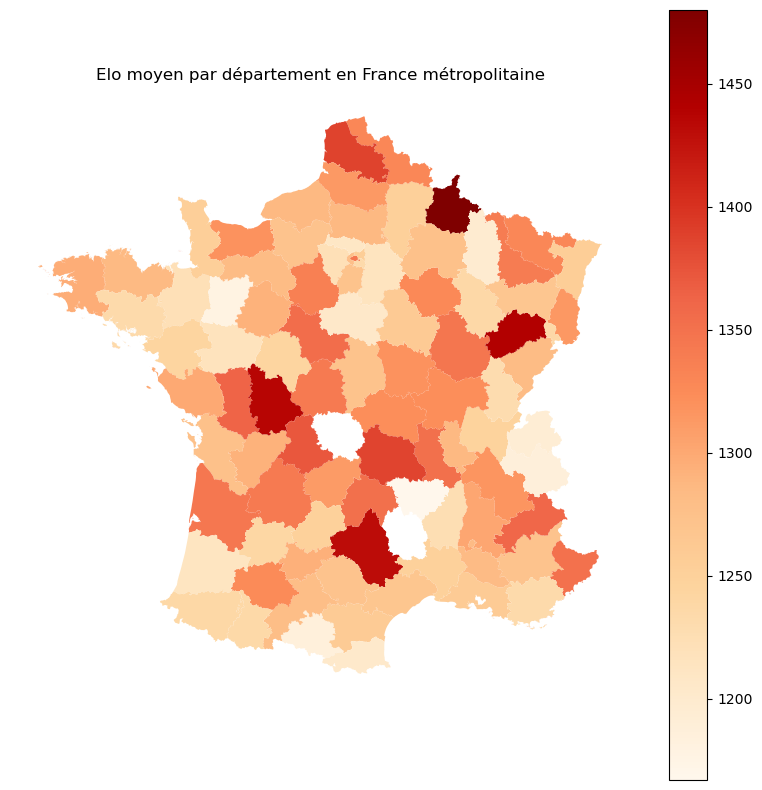

In [265]:
fig,ax = plt.subplots(figsize=(10, 10))
carte_departements_avec_elo.dissolve(by='INSEE_DEP', aggfunc='sum').plot(ax = ax, column = "elo_lent", legend=True, cmap='OrRd')
plt.title("Elo moyen par département en France métropolitaine")
ax.set_axis_off()
ax